In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.distributions import Categorical
from torch import optim
from torch import nn
from collections import deque
import numpy as np
import random
import warnings 
warnings.simplefilter('ignore')

# model

In [2]:
class critic(nn.Module):
    def __init__(self, input_dim):# state -> value
        super(critic, self).__init__()
        self.fc1 = nn.Linear(input_dim,128)
        self.fc2 = nn.Linear(128,1) 

    def forward(self, state):
        value = F.relu(self.fc1(state))
        value = self.fc2(value)
        return value

class actor(nn.Module):
    def __init__(self, input_dim, output_dim):# state -> action_probs
        super(actor, self).__init__()
        self.fc1 = nn.Linear(input_dim,128)
        self.fc2 = nn.Linear(128, output_dim)
    
    def forward(self, state):
        logits = F.relu(self.fc1(state))
        logits = F.sigmoid(self.fc2(logits))
        return F.softmax(logits*10,dim=-1)

# utils

In [3]:
class BasicBuffer:

    def __init__(self, max_size):
        self.max_size = int(max_size)
        self.buffer = deque(maxlen=int(max_size))

    def push(self, state, action, reward, next_state, done):
        experience = (state, action, np.array([reward]), next_state, done)
        self.buffer.append(experience)

    def sample(self, batch_size):
        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        done_batch = []

        batch = random.sample(self.buffer, batch_size)

        for experience in batch:
            state, action, reward, next_state, done = experience
            state_batch.append(state)
            action_batch.append(action)
            reward_batch.append(reward)
            next_state_batch.append(next_state)
            done_batch.append(done)

        return (state_batch, action_batch, reward_batch, next_state_batch, done_batch)

    def __len__(self):
        return len(self.buffer)

# agent

In [4]:
class PPOAgent:
    def __init__(self,env,gamma=0.99,lr=1e-3,clip=0.2,K_epoch=4,buffer_maxsize=10000):
        self.device = "cpu"
        
        # env
        self.env = env
        self.obs_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.n
        
        # Hyperparamters
        self.gamma = gamma
        self.lr = lr
        self.clip = clip
        self.K_epoch = K_epoch
        
        # critic
        self.critic = critic(self.obs_dim)
        self.critic.apply(self._weights_init)
        
        # actor_new
        self.actor_new = actor(self.obs_dim,self.action_dim)
        self.actor_new.apply(self._weights_init)
        
        # actor_old
        self.actor_old = actor(self.obs_dim,self.action_dim)
        self.sync()
        
        # opt
        self.actor_optimizer = optim.Adam(self.actor_new.parameters(),lr=lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(),lr=lr)
        
        # buffer
        self.replay_buffer = BasicBuffer(max_size=buffer_maxsize)
        
        # recorder
        self.recorder = {'a_loss':[],
                         'v_loss':[],
                         'ratio':[]}
            
    @staticmethod
    def _weights_init(m):
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight)
            nn.init.constant_(m.bias, 0.1)
    
    def sync(self):
        for old_param, new_param in zip(self.actor_old.parameters(),self.actor_new.parameters()):
            old_param.data.copy_(new_param.data)

    def get_action(self, state):
        state = torch.FloatTensor(state).to(self.device)
        probs = self.actor_new.forward(state) # softmax_probs
        dist = Categorical(probs) # Categorical distribution
        act = dist.sample() # smaple action from Categorical distribution
        return act.detach().item()

    def get_value(state):
        state = torch.FloatTensor(state).to(self.device)
        value = self.critic(state)
        return value.item()

    def update(self,batch_size=64):
        for k in range(self.K_epoch):
            
            # sample mini_batch_data from replay_buffer
            s,a,r,s_,d = self.replay_buffer.sample(batch_size)
            s = torch.FloatTensor(s).to(self.device)
            a = torch.LongTensor(a).to(self.device).unsqueeze(dim=1)
            r = torch.FloatTensor(r).to(self.device)
            s_ = torch.FloatTensor(s_).to(self.device)
            d = torch.FloatTensor(d).to(self.device).unsqueeze(dim=1)
            
            # critic loss
            v_target = r + self.gamma*self.critic(s_)*(1-d)
            v_current = self.critic(s)
            adv =  v_target - v_current
            v_loss = (adv**2).mean()
            self.recorder['v_loss'].append(v_loss.item())
            
            # actor loss
            new_logp = torch.gather(self.actor_new(s).log(),1,a)
            old_logp = torch.gather(self.actor_old(s).log(),1,a)
            ratio = torch.exp(new_logp - old_logp)
            self.recorder['ratio'].append(ratio.detach().numpy())
            surr1 = ratio*adv.detach()
            surr2 = torch.clamp(ratio,1-self.clip,1+self.clip)*adv.detach()
            a_loss = -torch.min(surr1,surr2).mean()
            self.recorder['a_loss'].append(a_loss.item())
            
            # update critic
            self.critic_optimizer.zero_grad()
            v_loss.backward()
            self.critic_optimizer.step()
            
            # update actor
            self.actor_optimizer.zero_grad()
            a_loss.backward()
            self.actor_optimizer.step()
        
        # sync
        self.sync()
            
    def train(self, max_episodes=100,max_steps=10000, batch_size=256):
        episode_rewards = []
        for episode in range(max_episodes):
            state = self.env.reset()
            episode_reward = 0
            for step in range(max_steps):
                action = self.get_action([state])
                next_state, reward, done, _ = self.env.step(action) 
                self.replay_buffer.push(state, action, reward, next_state, done)
                episode_reward += reward
                
                if len(self.replay_buffer) >= batch_size:
                    self.update(batch_size)
                    
                if done or step == max_steps-1:
                    episode_rewards.append(episode_reward)
                    print("Episode " + str(episode) + ": " + str(episode_reward))
                    break
                
                state = next_state
        
        return episode_rewards

In [5]:
import gym
env = gym.make("CartPole-v1")
agent = PPOAgent(env)
history = agent.train(max_episodes=100)

Episode 0: 16.0
Episode 1: 20.0
Episode 2: 12.0
Episode 3: 20.0
Episode 4: 9.0
Episode 5: 8.0
Episode 6: 13.0
Episode 7: 12.0
Episode 8: 11.0
Episode 9: 15.0
Episode 10: 16.0
Episode 11: 12.0
Episode 12: 10.0
Episode 13: 11.0
Episode 14: 10.0
Episode 15: 13.0
Episode 16: 19.0
Episode 17: 13.0
Episode 18: 9.0
Episode 19: 14.0
Episode 20: 59.0
Episode 21: 53.0
Episode 22: 12.0
Episode 23: 9.0
Episode 24: 63.0
Episode 25: 32.0
Episode 26: 133.0
Episode 27: 193.0
Episode 28: 198.0
Episode 29: 100.0
Episode 30: 136.0
Episode 31: 173.0
Episode 32: 164.0
Episode 33: 157.0
Episode 34: 201.0
Episode 35: 131.0
Episode 36: 142.0
Episode 37: 170.0
Episode 38: 123.0
Episode 39: 115.0
Episode 40: 334.0
Episode 41: 165.0
Episode 42: 238.0
Episode 43: 117.0
Episode 44: 146.0
Episode 45: 201.0
Episode 46: 148.0
Episode 47: 231.0
Episode 48: 255.0
Episode 49: 126.0
Episode 50: 156.0
Episode 51: 237.0
Episode 52: 165.0
Episode 53: 191.0
Episode 54: 175.0
Episode 55: 148.0
Episode 56: 110.0
Episode 57: 19

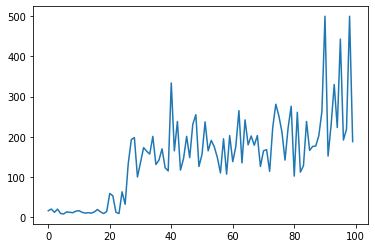

In [9]:
import matplotlib.pyplot as plt

plt.plot(history)
plt.show()

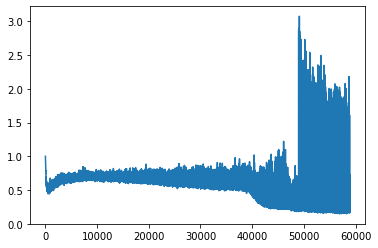

In [7]:
plt.plot(agent.recorder['v_loss'])

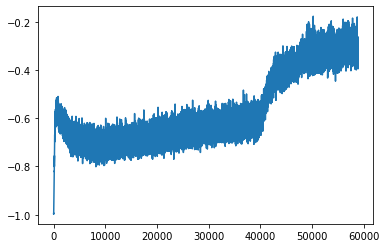

In [8]:
plt.plot(agent.recorder['a_loss'])

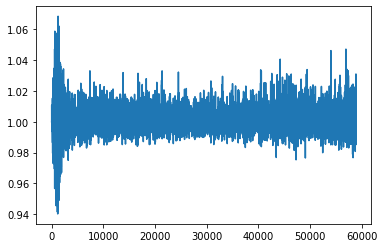

In [18]:
plt.plot(np.array(agent.recorder['ratio']).mean(axis=1))